In [71]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from torchsummary import summary

In [72]:
path = r'C:\Users\CHOI.DESKTOP-R51MDOU\Downloads\Mall_Customers.csv'
df = pd.read_csv(path)
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [73]:
df.columns

Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

In [74]:
missing_values = df.isnull().sum()

print(missing_values)

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [75]:
label_encoder = LabelEncoder()

# 엔코딩할 column 리스트
columns_to_encode = ['Gender']

# 선택한 column의 label을 숫자로 엔코딩
for column in columns_to_encode:
    df[column] = label_encoder.fit_transform(df[column])

df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,1,19,15,39
1,2,1,21,15,81
2,3,0,20,16,6
3,4,0,23,16,77
4,5,0,31,17,40
...,...,...,...,...,...
195,196,0,35,120,79
196,197,0,45,126,28
197,198,1,32,126,74
198,199,1,32,137,18


In [76]:
df.drop(columns = 'CustomerID')

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40
...,...,...,...,...
195,0,35,120,79
196,0,45,126,28
197,1,32,126,74
198,1,32,137,18


In [77]:
X = df.drop('Spending Score (1-100)', axis = 1).values
y = df['Spending Score (1-100)'].values

In [78]:
#데이터 정규화
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 특성과 타겟 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [79]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, 

((160, 4), (40, 4), (160,), (40,))

In [80]:
X_train = torch.tensor(X_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.int64)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.int64)

In [81]:
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size = 25, shuffle = True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size = 25, shuffle = False)

In [82]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([160, 4]),
 torch.Size([40, 4]),
 torch.Size([160]),
 torch.Size([40]))

In [83]:
# model 정의
class SpendingScoreDense(nn.Module) :
    def __init__(self):
        super(SpendingScoreDense, self).__init__()
        self.fc1 = nn.Linear(4, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 8)
        self.fc5 = nn.Linear(8, 1)  
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Initialize the model, loss function, and optimizer
model = SpendingScoreDense()

In [84]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [85]:
train_losses = []
test_accuracies = []

# 학습 루프
num_epochs = 40
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:

        labels = labels.float() # convert long type as float type
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss over an epoch
    train_losses.append(running_loss / len(train_dataloader))

    # Evaluate on test data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}")

print("학습 완료.")

C:\Users\CHOI.DESKTOP-R51MDOU\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([25])) that is different to the input size (torch.Size([25, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\CHOI.DESKTOP-R51MDOU\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/40, Loss: 3171.0691
Epoch 2/40, Loss: 3184.1264
Epoch 3/40, Loss: 3098.1774
Epoch 4/40, Loss: 3010.5624
Epoch 5/40, Loss: 3186.8849
Epoch 6/40, Loss: 2967.7077
Epoch 7/40, Loss: 3116.5346
Epoch 8/40, Loss: 3131.2992
Epoch 9/40, Loss: 3086.3005
Epoch 10/40, Loss: 3068.6421
Epoch 11/40, Loss: 3061.4925
Epoch 12/40, Loss: 3005.7287
Epoch 13/40, Loss: 2959.7575
Epoch 14/40, Loss: 2948.8548
Epoch 15/40, Loss: 2869.9534
Epoch 16/40, Loss: 2863.0630
Epoch 17/40, Loss: 2649.5528
Epoch 18/40, Loss: 2637.0005
Epoch 19/40, Loss: 2555.1281
Epoch 20/40, Loss: 2328.9919
Epoch 21/40, Loss: 2095.7248
Epoch 22/40, Loss: 1964.8332
Epoch 23/40, Loss: 1669.1876
Epoch 24/40, Loss: 1421.2354
Epoch 25/40, Loss: 1145.3241
Epoch 26/40, Loss: 971.4199
Epoch 27/40, Loss: 849.7657
Epoch 28/40, Loss: 778.5065
Epoch 29/40, Loss: 766.1054
Epoch 30/40, Loss: 753.6004
Epoch 31/40, Loss: 753.9045
Epoch 32/40, Loss: 719.5388
Epoch 33/40, Loss: 716.3688
Epoch 34/40, Loss: 732.8012
Epoch 35/40, Loss: 750.0315
Epoc

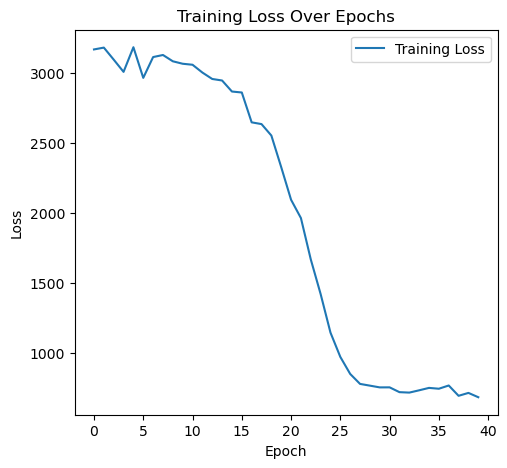

In [86]:
plt.figure(figsize = (12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label = 'Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()